# I. Perkenalan

> Nama : Handwitanto  
> Batch : RMT_36  
> Dataset : [Insurance.csv](https://raw.githubusercontent.com/FTDS-learning-materials/datasets/main/insurance.csv)

# II. Business Understanding

## SMART

Untuk memahami biaya asuransi kesehatan di USA, kami akan melakukan analisa dataset untuk menentukan faktor-faktor yang mempengaruhi dan memberikan kisaran biaya yang dapat diukur menggunakan model Machine Learning

## Problem Statement


> Berapa biaya yang harus dikeluarkan untuk mendapatkan asuransi kesehatan di USA? Untuk menjawab pertanyaan ini, kami akan melakukan analisis pada dataset terkait asuransi kesehatan untuk menghitung dan mendapatkan kisaran biaya yang diperlukan. Riset ini akan dilakukan dengan mempertimbangkan berbagai faktor yang memengaruhi besaran premi asuransi, seperti usia, lokasi, dan kondisi kesehatan. Dalam waktu kurang dari 1 minggu, analisis data ini diharapkan dapat memberikan gambaran kisaran biaya asuransi yang dibutuhkan berdasarkan faktor-faktor tersebut.

# III. Data Loading

> i. Import Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

> ii. Load Data

In [2]:
#Load Datase
df_ori = pd.read_csv("https://raw.githubusercontent.com/FTDS-learning-materials/datasets/main/insurance.csv")

#duplicate
df = df_ori.copy()

#show data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
#check dataset 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
#check dataset 2
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


>> Dapat dilihat bahwa angka biaya `health-insurance` terkecil adalah `$1121`, dengan nilai rata-rata `$13270`, sehingga perlu dilakukan pengecekan outlier pada dataset

In [5]:
#check dataset 3
df.duplicated().sum()

1

In [6]:
#drop duplicate
df.drop_duplicates(inplace=True)

In [7]:
#re-check duplicate
df.duplicated().sum()

0

#  IV. Exploratory Data Analysis (EDA)

> OBJ 1 : Melihat persebaran data `charge` pada dataset dan juga melihat proporsi perbandingan `charge vs age`, `charge vs children`, dan `charge vs bmi`

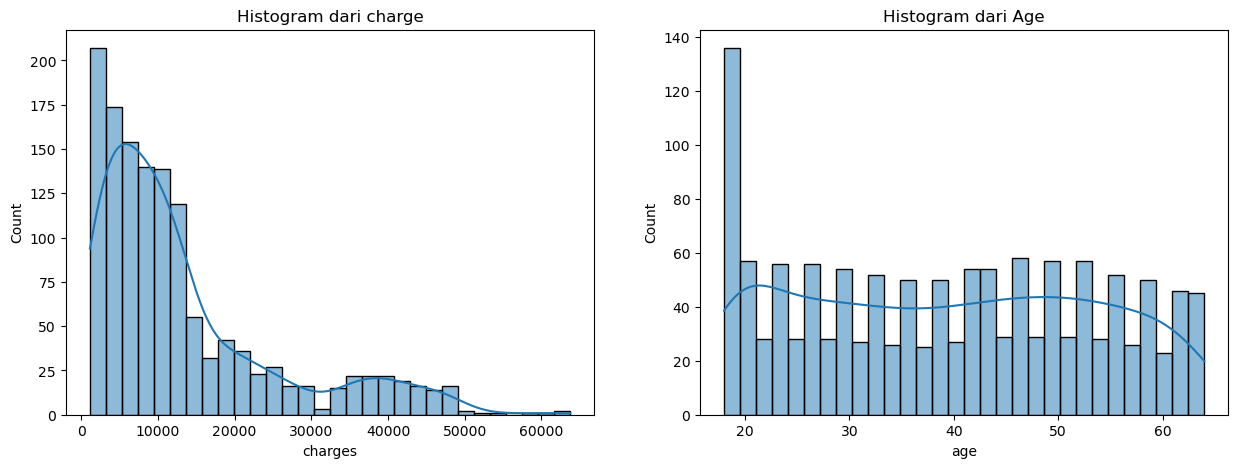

Skewness dari Charges : 1.5153909108403483
Skewness dari Age : 0.054780773126998195


In [8]:
#create canvas
plt.figure(figsize=(15,5))

#plot 1
plt.subplot (1,2,1)
sns.histplot(df.charges, kde=True, bins=30)
plt.title('Histogram dari charge')

#plot 2
plt.subplot (1,2,2)
sns.histplot(df.age, kde=True, bins=30)
plt.title('Histogram dari Age')

plt.show()
print (f"Skewness dari Charges : {df['charges'].skew()}")
print (f"Skewness dari Age : {df['age'].skew()}")

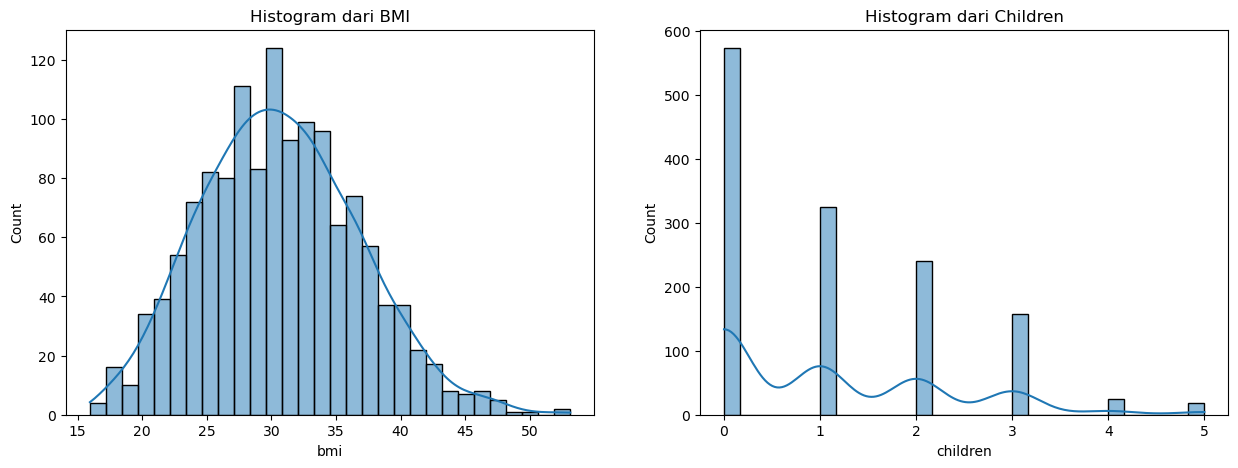

Skewness dari BMI : 0.28391419385321137
Skewness dari Children : 0.9374206440474123


In [9]:
#create canvas
plt.figure(figsize=(15,5))

#plot 1
plt.subplot (1,2,1)
sns.histplot(df.bmi, kde=True, bins=30)
plt.title('Histogram dari BMI')

#plot 2
plt.subplot (1,2,2)
sns.histplot(df.children, kde=True, bins=30)
plt.title('Histogram dari Children')

plt.show()
print (f"Skewness dari BMI : {df['bmi'].skew()}")
print (f"Skewness dari Children : {df['children'].skew()}")

> Dapat terlihat bahwa persebaran data `charges` tidak normal

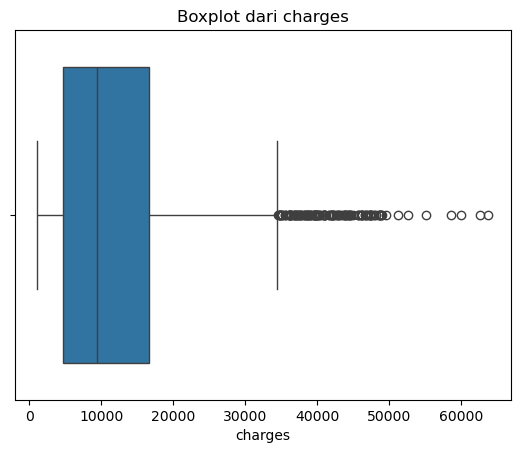

In [10]:
sns.boxplot(x=df['charges'])
plt.title('Boxplot dari charges')
plt.show()

> ditemukan adanya outlier pada data

> Cek korelasi dengan kolom `charges`

In [11]:
df_num = pd.get_dummies(df, drop_first=True)
correlation = df_num.corr()
charges_corr = correlation['charges'].sort_values(ascending=False)

print(charges_corr)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64


> Berdasarkan informasi di atas, dapat disimpulkan : 
- terdapat korelasi positif antara biaya health-insurance untuk individu yang merokok. 
- semakin tua usia, semakin tinggi biaya health-insurancenya
- nilai BMI mempengaruhi biaya health-insurance

In [41]:
charges_smoker = df.groupby('smoker')['charges'].mean()
print (f"Rata-rata biaya Health-Insurance berdasarkan smoker: {charges_smoker}")
print ("\n")
charges_region = df.groupby('region')['charges'].mean()
print (f"Rata-rata biaya Health-Insurance berdasarkan region: {charges_region}")
print ("\n")
charges_sex = df.groupby('sex')['charges'].mean()
print (f"Rata-rata biaya Health-Insurance berdasarkan smoker: {charges_sex}")


Rata-rata biaya Health-Insurance berdasarkan smoker: smoker
no      8440.660307
yes    32050.231832
Name: charges, dtype: float64


Rata-rata biaya Health-Insurance berdasarkan region: region
northeast    13406.384516
northwest    12450.840844
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64


Rata-rata biaya Health-Insurance berdasarkan smoker: sex
female    12569.578844
male      13974.998864
Name: charges, dtype: float64


> status Merokok atau tidak sangat mempengaruhi nilai dari `Charges`

# V. Feature Engineering

> Cek Outlier

In [12]:
#cek outlier Age
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3-q1
low_bound = q1-1.5*iqr
up_bound = q3+1.5*iqr

outlier = df['age'][(df['age']<low_bound) | (df['age']>up_bound)]

print (f"Lower Boundaries : {low_bound}")
print (f"Upper Boundaries : {up_bound}")
print (f"persen outlier : {len(outlier)*100/len(df['age']):.2f}%")

Lower Boundaries : -9.0
Upper Boundaries : 87.0
persen outlier : 0.00%


In [13]:
#cek outlier BMI
q1 = df['bmi'].quantile(0.25)
q3 = df['bmi'].quantile(0.75)
iqr = q3-q1
low_bound = q1-1.5*iqr
up_bound = q3+1.5*iqr

outlier = df['bmi'][(df['bmi']<low_bound) | (df['bmi']>up_bound)]

print (f"Lower Boundaries : {low_bound}")
print (f"Upper Boundaries : {up_bound}")
print (f"persen outlier : {len(outlier)*100/len(df['bmi']):.2f}%")

Lower Boundaries : 13.674999999999994
Upper Boundaries : 47.31500000000001
persen outlier : 0.67%


In [14]:
#cek outlier children
q1 = df['children'].quantile(0.25)
q3 = df['children'].quantile(0.75)
iqr = q3-q1
low_bound = q1-1.5*iqr
up_bound = q3+1.5*iqr

outlier = df['children'][(df['children']<low_bound) | (df['children']>up_bound)]

print (f"Lower Boundaries : {low_bound}")
print (f"Upper Boundaries : {up_bound}")
print (f"persen outlier : {len(outlier)*100/len(df['children']):.2f}%")

Lower Boundaries : -3.0
Upper Boundaries : 5.0
persen outlier : 0.00%


In [15]:
df['charges'].describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [16]:
#cek outlier
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3-q1
low_bound = q1-1.5*iqr
up_bound = q3+1.5*iqr

outlier = df['charges'][(df['charges']<low_bound) | (df['charges']>up_bound)]

print (f"Lower Boundaries : {low_bound}")
print (f"Upper Boundaries : {up_bound}")
print (f"persen outlier : {len(outlier)*100/len(df['charges']):.2f}%")


Lower Boundaries : -13120.716174999998
Upper Boundaries : 34524.777625
persen outlier : 10.40%


> Persentase Outlier untuk kolom `charges` lebih dari 10%, bisa di artikan bahwa outlier yang ada bukan karena salah input, tapi memang data real. Sehingga penanganan yang dipilih adalah membuat kolom baru yang berisi log dari kolom `charges`, sehingga pesebaran data menjadi normal, karena jika outlier dibiarkan, membuat analisa data menjadi lebih sulit untuk mendapatkan hasil yang akurat

In [17]:
#Outlier handling, agar pesebaran data menjadi normal untuk analisa lebih akurat
df['charges_log'] = np.log1p(df['charges']) #Compress value kolom charges, simpan pada charges_log agar tidak mengubah data original

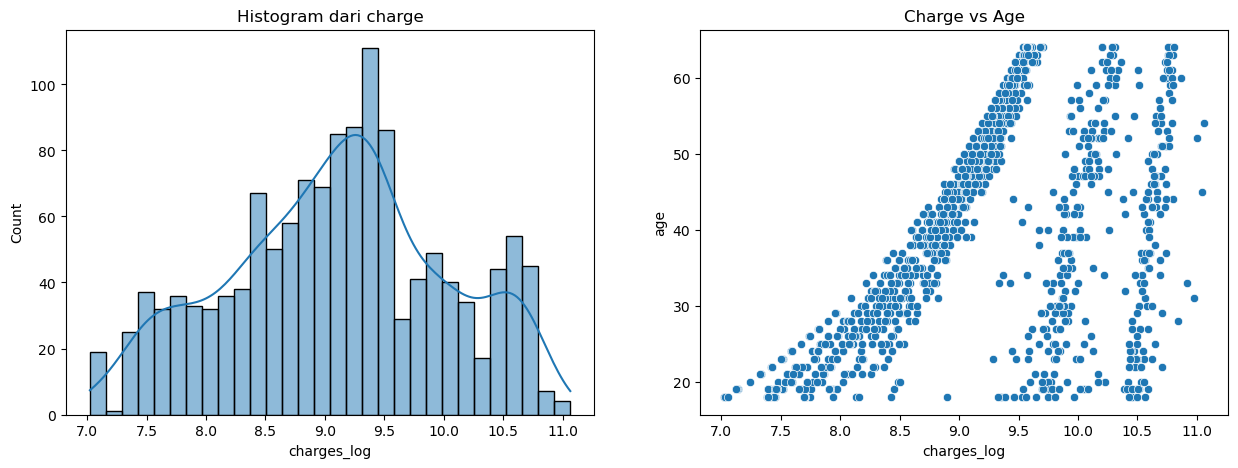

In [18]:
#create canvas
plt.figure(figsize=(15,5))

#plot 1
plt.subplot (1,2,1)
sns.histplot(df.charges_log, kde=True, bins=30)
plt.title('Histogram dari charge')

#plot 2
plt.subplot(1,2,2)
sns.scatterplot(x='charges_log', y='age', data=df)
plt.title('Charge vs Age')

plt.show()

> dapat dilihat pesebaran datanya sudah normal

## i. Split X (features) dan y(target)

In [19]:
#split x dan y
x = df.drop(['charges', 'charges_log'], axis=1)
y = df.charges_log

In [ ]:
x.head()

In [ ]:
y.head()

## ii. Split Train and Test

In [20]:
#split train and test
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=42)

print (f"train size : {x_train.shape}")
print (f"test size : {x_test.shape}")
print (x_train)

train size : (1069, 6)
test size : (268, 6)
      age     sex     bmi  children smoker     region
1114   23    male  24.510         0     no  northeast
968    21    male  25.745         2     no  northeast
599    52  female  37.525         2     no  northwest
170    63    male  41.470         0     no  southeast
275    47  female  26.600         2     no  northeast
...   ...     ...     ...       ...    ...        ...
1096   51  female  34.960         2    yes  northeast
1131   27    male  45.900         2     no  southwest
1295   20    male  22.000         1     no  southwest
861    38  female  28.000         3     no  southwest
1127   35  female  35.860         2     no  southeast

[1069 rows x 6 columns]


## iii. Missing Value

In [21]:
x_train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [24]:
x_test.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [23]:
y_train.isnull().sum()

0

In [25]:
y_test.isnull().sum()

0

## iv. Cardinality Check

In [26]:
num_col = ['age','bmi','children']
cat_col = ['sex','smoker','region']

x_train_num = x_train[num_col]
x_test_num = x_test[num_col]

x_train_cat = x_train[cat_col]
x_test_cat = x_test[cat_col]

In [27]:
x_train_cat.nunique()

sex       2
smoker    2
region    4
dtype: int64

> Low-Cardinality, proses selanjutnya menggunakan `OneHotEncoder`

## v. Feature Scaling

In [28]:
#scaling Method
scaler = MinMaxScaler()
#.fit
scaler.fit(x_train_num)
#.transform
x_train_num_scaled = scaler.transform(x_train_num)
x_test_num_scaled = scaler.transform(x_test_num)


In [29]:
x_train_num_scaled

array([[0.10869565, 0.23002421, 0.        ],
       [0.06521739, 0.26324993, 0.4       ],
       [0.73913043, 0.58017218, 0.4       ],
       ...,
       [0.04347826, 0.16249664, 0.2       ],
       [0.43478261, 0.32391714, 0.6       ],
       [0.36956522, 0.53537799, 0.4       ]])

## vi. Feature Encoding

In [ ]:
print (x_train_cat.sex.unique())
print (x_train_cat.smoker.unique())
print (x_train_cat.region.unique())
x_train_cat.head()

In [30]:
#encode categorial columns
encoder = OneHotEncoder(categories=[
    ['female','male'], ['no','yes'],['northwest','northeast','southeast','southwest']
    ], sparse_output=False)
encoder.fit(x_train_cat)
x_train_cat_encoded = encoder.transform(x_train_cat)
x_test_cat_encoded = encoder.transform(x_test_cat)

In [31]:
x_train_cat_encoded

array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [32]:
#penggabungan kolom categorical dan numerical yang sudah di encoded/scaled
x_train_final = np.concatenate([x_train_cat_encoded, x_train_num_scaled], axis=1)
x_test_final = np.concatenate([x_test_cat_encoded, x_test_num_scaled], axis=1)
x_train_final

array([[0.        , 1.        , 1.        , ..., 0.10869565, 0.23002421,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.06521739, 0.26324993,
        0.4       ],
       [1.        , 0.        , 1.        , ..., 0.73913043, 0.58017218,
        0.4       ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.04347826, 0.16249664,
        0.2       ],
       [1.        , 0.        , 1.        , ..., 0.43478261, 0.32391714,
        0.6       ],
       [1.        , 0.        , 1.        , ..., 0.36956522, 0.53537799,
        0.4       ]])

## vii. Model Definition

> Algoritma yang dipakai : `LinearRegression`  
karena dataset yang digunakan cukup simple, dan target yang akan dicapai `(charges_log)`  
> Metrics yang dipakai : `MAE`  
karena untuk melihat sejauh mana error dari prediksinya

In [33]:
#define model, RandomForestRegressor digunakan karena toleransi yang lebih tinggi terhadap outlier atau pesebaran data yang tidak normal
model = RandomForestRegressor(n_estimators=100, random_state=42)


## viii. Model Training

In [34]:
#Train the model
model.fit(x_train_final, y_train)

RandomForestRegressor(random_state=42)

## ix. Model Evaluation

In [35]:
#predict Train dan Test
y_pred_train = model.predict(x_train_final)
y_pred_test = model.predict(x_test_final)

print (y_pred_train)

[ 7.82475248  8.14653089 10.05837011 ...  7.71504099  8.87185925
  8.67636836]


In [ ]:
y_train

In [36]:
#evaluate the model
print ('Error - Train : ', mean_absolute_error(y_train, y_pred_train))
print ('Error - Test : ', mean_absolute_error(y_test, y_pred_test))

y_pred_original = np.expm1(y_pred_test)
y_test_original = np.expm1(y_test)

mae_original = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test, y_pred_test)

print (f"MAE pada original scale : {mae_original:.2f}")
print (f"R**2 Score: {r2}")



Error - Train :  0.07981779375974878
Error - Test :  0.19137441258859259
MAE pada original scale : 2048.69
R**2 Score: 0.850368201117657


# VI. Feature Importance

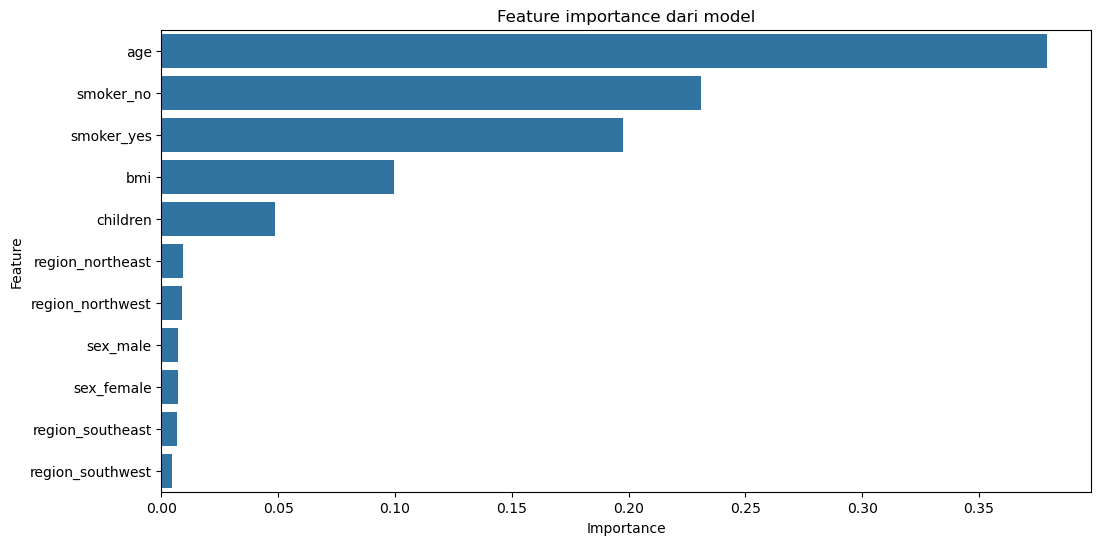

In [37]:
importances = model.feature_importances_
features = encoder.get_feature_names_out(cat_col).tolist() + num_col
feature_importances_df = pd.DataFrame({'Feature':features, 'Importance':importances})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature importance dari model')
plt.show()

# VII. Model saving for inference

In [39]:
#save into file
with open('model.pkl', 'wb') as file_1:
    pickle.dump (model, file_1)
with open('model_scaler.pkl', 'wb') as file_2:
    pickle.dump (scaler, file_2)
with open('model_encoder.pkl', 'wb') as file_3:
    pickle.dump (encoder, file_3)
with open('num_col.txt', 'w') as file_4:
    json.dump (num_col, file_4)
with open('cat_col.txt', 'w') as file_5:
    json.dump (cat_col, file_5)
